<a href="https://colab.research.google.com/github/aquangnguyen1992/Advanced_Data_Science_Capstone/blob/master/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Get the dataset from Kaggle***

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
!kaggle competitions download -c ieee-fraud-detection
!unzip \*.zip  && rm *.zip

# ***Analyzing the dataset and doing the cleansing***

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import copy
import os
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
os.chdir("/content")
dataset_transaction = pd.read_csv('train_transaction.csv')
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
dataset_identity = pd.read_csv('train_identity.csv')
dataset_identity.head(5)
saved_columns= np.array(dataset_identity.columns)

In [ ]:
dataset_identity.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [ ]:
dataset_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

In [ ]:
#Data transaction
float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
to_remove_NaN_dataset_transaction = []
removed = 0
for column in float_columns:
  count_NaN = np.sum(np.isnan(dataset_transaction[column].values))
  if count_NaN/len(dataset_transaction[column].values) > 0.9:
    to_remove_NaN_dataset_transaction.append(column)
    dataset_transaction.pop(column)
    removed += 1
print("Removed: " + str(removed))

Removed: 167


In [57]:
float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
to_remove_NaN_dataset_transaction = []
removed = 0
for column in float_columns:
  count_NaN = np.sum(np.isnan(dataset_transaction[column].values))
  if count_NaN/len(dataset_transaction[column].values) > 0.9:
    to_remove_NaN_dataset_transaction.append(column)

for column in to_remove_NaN_dataset_transaction:
  print(column)
  data_test = dataset_transaction[column]
  indices = np.where(np.isnan(data_test) == False)[0]
  data_b = dataset_transaction.iloc[indices]
  indices_fraud = np.where(data_b['isFraud'] == 1)[0]
  print("Not NaN:" + str(len(indices)) + "; " + str(len(indices_fraud)) + "; " + str(len(indices_fraud)/len(indices)*100))

  indices = np.where(np.isnan(data_test) == True)[0]
  data_b = dataset_transaction.iloc[indices]
  indices_fraud = np.where(data_b['isFraud'] == 1)[0]
  print("% NaN: " + str(len(indices)/len(data_test)*100))
  print("NaN:" + str(len(indices)) + "; " + str(len(indices_fraud)) + "; " + str(len(indices_fraud)/len(indices)*100))


dist2
Not NaN:37627; 3731; 9.915751986605363
% NaN: 93.62837403054831
NaN:552913; 16932; 3.0623262610935176
D7
Not NaN:38917; 5790; 14.877816892360665
% NaN: 93.40992989467267
NaN:551623; 14873; 2.6962255018373056


In [ ]:
# Dataset Identity
float_columns = dataset_identity.columns[np.where(dataset_identity.dtypes == np.dtype('float64'))].to_list()
to_remove_NaN_dataset_identity = []
removed = 0
for column in float_columns:
  count_NaN = np.sum(np.isnan(dataset_identity[column].values))
  if count_NaN/len(dataset_identity[column]) > 0.75:
    to_remove_NaN_dataset_identity.append(column)
    dataset_identity.pop(column)
    removed += 1
print("Removed: " + str(removed))


In [5]:
to_remove_id = ['DeviceInfo', 'id_30', 'id_31', 'id_33']
for column in to_remove_id:
  dataset_identity.pop(column)

In [6]:
merged_data = pd.merge(left=dataset_transaction, right=dataset_identity, how='left', left_on='TransactionID', right_on='TransactionID')

dataset_transaction = None
dataset_identity = None
merged_data.shape

(590540, 430)

In [7]:
################################# Test ##########################################
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv', names=saved_columns, header=0)

for column in to_remove_id:
  test_identity.pop(column)

test_merged_data = pd.merge(left=test_transaction, right=test_identity, how='left', left_on='TransactionID', right_on='TransactionID')

TransactionID = test_merged_data.pop('TransactionID')
test_transaction = None
test_identity = None
test_merged_data.shape

################################################################################

(506691, 428)

In [33]:
merged_data.tail(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,credit,299.0,87.0,NaN,NaN,gmail.com,NaN,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Check NaN, Null, and OneHotEncoding**

In [8]:
dataset_transaction = copy.copy(merged_data)
merged_data = None
dataset_identity = None

float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('O'))].to_list()

skip_int_columns = ['TransactionID', 'isFraud']
for column in skip_int_columns:
  int_columns.remove(column)

skip_obj_colums = ['']
cache = dict()
print(len(float_columns), len(int_columns), len(obj_columns))

399 2 27


In [10]:
def normalization_data(X, indices, max_test, min_test):
  X_out = copy.copy(X)
  X_temp = X[indices]
  max_X = np.max([np.max(X_temp), max_test])
  min_X = np.min([np.min(X_temp), min_test])
  mean_X = np.mean(X_temp)
  median_X = np.median(X_temp)
  #X_out.iloc[indices] = (X_temp - mean_X)/(max_X - min_X)
  X_out.iloc[np.where(np.isnan(X_out))[0]] = median_X
  X_out = (X_out - mean_X)/(max_X - min_X) # So from -1 to 1

  return min_X, max_X, mean_X, median_X, X_out.astype('float16')

In [9]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,32.0,match_status:2,T,F,T,T,mobile


In [11]:
# Task 1: Detect the columns with NaN and code it with an extra features
# Task 2: Apply normalizationn
# Task 3: Remove the irrelevant columns
for column in float_columns:
  # Set to float 16
  dataset_transaction[column].astype('float32')

  # Code the NaN column for every features
  #dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(X) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], cache[column+'_median'], dataset_transaction[column] = normalization_data(X, indices, np.max(test_merged_data[column]), np.min(test_merged_data[column]))
  dataset_transaction[column].astype('float16')

In [11]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
0,2987000,0,86400,-0.004227,W,13926,-0.003111,-1.169922,discover,-1.458008,credit,-0.660645,-0.943359,-0.011520,-0.016769,NaN,NaN,-0.003008,-0.002684,-0.000225,-0.001817,-0.016006,-0.004028,-0.001264,-0.001545,-0.021408,-0.00161,-0.003214,-0.001279,-0.011154,-0.00581,-0.147583,-0.113403,-0.034637,-0.115051,-0.039490,-0.072998,-0.049408,-0.063354,0.110229,...,-0.000517,-0.000532,-0.001452,-0.000968,0.051697,-0.048950,-0.002617,0.002106,-0.013031,0.067017,0.00668,0.04599,-0.001493,0.003012,0.025467,NaN,0.07312,0.032257,NaN,NaN,-0.181763,0.040131,-0.021240,0.121399,-0.154175,-0.058899,NaN,-0.120056,-0.019211,-0.000606,NaN,NaN,NaN,-0.078369,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,-0.004227,W,2755,-0.725098,-1.169922,mastercard,-1.459961,credit,-0.660645,-0.943359,-0.010742,-0.016769,gmail.com,NaN,-0.003008,-0.002684,-0.000225,-0.001817,-0.016006,-0.004028,-0.001264,-0.001545,-0.021439,-0.00161,-0.003214,-0.001279,-0.011154,-0.00581,-0.147705,-0.113403,-0.024841,-0.141357,-0.039490,-0.072998,-0.049408,-0.063354,0.110229,...,-0.000517,-0.000532,-0.001452,-0.000968,0.051697,-0.048950,-0.002617,0.002106,-0.013031,0.067017,0.00668,0.04599,-0.001493,0.003012,0.025467,NaN,0.07312,0.032257,NaN,NaN,-0.181763,0.040131,-0.021240,0.121399,-0.154175,-0.058899,NaN,-0.120056,-0.019211,-0.000606,NaN,NaN,NaN,-0.078369,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,-0.004227,W,4663,-0.724609,-1.169922,visa,-1.456055,debit,-0.660645,-0.943359,-0.011520,-0.016769,outlook.com,NaN,-0.003008,-0.002684,-0.000225,-0.001817,-0.016006,-0.004028,-0.001264,-0.001545,-0.021408,-0.00161,-0.003214,-0.001279,-0.011154,-0.00581,-0.147705,-0.113403,-0.024841,-0.141357,-0.039490,-0.072998,-0.049408,-0.063354,0.110229,...,-0.000517,-0.000532,-0.001452,-0.000968,0.051697,-0.048950,-0.002617,0.002106,-0.013031,0.067017,0.00668,0.04599,-0.001493,0.003012,0.025467,NaN,0.07312,0.032257,NaN,NaN,-0.181763,0.040131,-0.021240,0.121399,-0.154175,-0.058899,NaN,-0.120056,-0.019211,-0.000606,NaN,NaN,NaN,-0.078369,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,-0.004227,W,18132,-0.724121,-1.169922,mastercard,-1.458984,debit,-0.659668,-0.943359,-0.010742,-0.016769,yahoo.com,NaN,-0.003008,-0.002684,-0.000225,-0.001817,-0.016006,-0.004028,-0.001264,-0.001545,-0.021408,-0.00161,-0.003214,-0.001279,-0.011154,-0.00581,-0.147339,-0.265137,-0.034637,-0.141357,-0.051758,-0.072998,-0.049408,-0.063354,0.110229,...,-0.000517,-0.000532,-0.001452,-0.000968,0.051697,-0.048950,-0.002617,0.002106,-0.013031,0.067017,0.00668,0.04599,-0.001493,0.003012,0.025467,NaN,0.07312,0.032257,NaN,NaN,-0.181763,0.040131,-0.021240,0.121399,-0.154175,-0.058899,NaN,-0.120056,-0.019211,-0.000606,NaN,NaN,NaN,-0.078369,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,-0.004227,H,4497,-0.724609,-1.169922,mastercard,-1.459961,credit,-0.660156,-0.943359,-0.010742,-0.016769,gmail.com,NaN,-0.003008,-0.002684,-0.000225,-0.001817,-0.016006,-0.004028,-0.001264,-0.001545,-0.021439,-0.00161,-0.003214,-0.001279,-0.011154,-0.00581,-0.147705,-0.113403,-0.024841,-0.115051,-0.039490,-0.072998,-0.049408,-0.063354,0.110229,...,-0.000517,-0.000532,-0.001452,-0.000968,0.102722,-0.174805,-0.002617,0.002106,-0.013031,0.067017,0.00668,0.04599,-0.001493,0.003012,-9.968750,NotFound,0.07312,0.249512,New,NotFound,-1.469727,0.040131,-0.617676,-0.720703,-0.154175,-0.058899,NaN,-0.120056,-0.019211,-0.000606,NaN,New,NotFound,-0.823242,match_status:2,T,F,T,T,mobile


In [12]:
for column in int_columns:
  # Set to int 32
  dataset_transaction[column].astype('float32')

  # Code the NaN feature
  #dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], cache[column+'_median'], dataset_transaction[column] = normalization_data(X, indices, np.max(test_merged_data[column]), np.min(test_merged_data[column]))

In [11]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
0,2987000,0,-0.463379,-0.002083,W,0.231445,-0.003111,-0.024384,discover,-0.418213,credit,0.055145,0.002167,-0.009674,-0.016769,NaN,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,-0.113403,-0.018738,-0.115051,-0.039490,-0.072998,-0.049408,-0.063354,0.110229,...,-0.000517,-0.000532,-0.001452,-0.000968,0.051697,-0.048950,-0.002617,0.002106,-0.013031,0.067017,0.00668,0.04599,-0.001493,0.003012,0.025467,NaN,0.07312,0.032257,NaN,NaN,-0.181763,0.040131,-0.021240,0.121399,-0.154175,-0.058899,NaN,-0.120056,-0.019211,-0.000606,NaN,NaN,NaN,-0.078369,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,-0.463379,-0.003321,W,-0.410645,0.082886,-0.024384,mastercard,-0.709961,credit,0.077881,0.002167,-0.010742,-0.016769,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,-0.113403,-0.024841,-0.141235,-0.039490,-0.072998,-0.049408,-0.063354,0.110229,...,-0.000517,-0.000532,-0.001452,-0.000968,0.051697,-0.048950,-0.002617,0.002106,-0.013031,0.067017,0.00668,0.04599,-0.001493,0.003012,0.025467,NaN,0.07312,0.032257,NaN,NaN,-0.181763,0.040131,-0.021240,0.121399,-0.154175,-0.058899,NaN,-0.120056,-0.019211,-0.000606,NaN,NaN,NaN,-0.078369,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,-0.463379,-0.002380,W,-0.301025,0.254883,-0.024384,visa,-0.242920,debit,0.089233,0.002167,0.016388,-0.016769,outlook.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,-0.113403,-0.024841,-0.141235,-0.039490,-0.072998,-0.049408,-0.063354,0.110229,...,-0.000517,-0.000532,-0.001452,-0.000968,0.051697,-0.048950,-0.002617,0.002106,-0.013031,0.067017,0.00668,0.04599,-0.001493,0.003012,0.025467,NaN,0.07312,0.032257,NaN,NaN,-0.181763,0.040131,-0.021240,0.121399,-0.154175,-0.058899,NaN,-0.120056,-0.019211,-0.000606,NaN,NaN,NaN,-0.078369,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,-0.463379,-0.002663,W,0.473389,0.408936,-0.024384,mastercard,-0.600586,debit,0.421143,0.002167,-0.010742,-0.016769,yahoo.com,NaN,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,-0.072998,-0.049408,-0.063354,0.110229,...,-0.000517,-0.000532,-0.001452,-0.000968,0.051697,-0.048950,-0.002617,0.002106,-0.013031,0.067017,0.00668,0.04599,-0.001493,0.003012,0.025467,NaN,0.07312,0.032257,NaN,NaN,-0.181763,0.040131,-0.021240,0.121399,-0.154175,-0.058899,NaN,-0.120056,-0.019211,-0.000606,NaN,NaN,NaN,-0.078369,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,-0.463379,-0.002663,H,-0.310547,0.302979,-0.024384,mastercard,-0.709961,credit,0.293701,0.002167,-0.010742,-0.016769,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,-0.113403,-0.024841,-0.115051,-0.039490,-0.072998,-0.049408,-0.063354,0.110229,...,-0.000517,-0.000532,-0.001452,-0.000968,0.101685,-0.103943,-0.002617,0.002106,-0.013031,0.067017,0.00668,0.04599,-0.001493,0.003012,0.025467,NotFound,0.07312,-0.098206,New,NotFound,-0.181763,0.040131,0.330811,-0.463135,-0.154175,-0.058899,NaN,-0.120056,-0.019211,-0.000606,NaN,New,NotFound,0.171631,match_status:2,T,F,T,T,mobile


In [13]:
from sklearn.preprocessing import OneHotEncoder

encoded_column = 0
for column in obj_columns:
  ohc = OneHotEncoder()
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.fit_transform(dataset_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(dataset_transaction[column].astype('str'))))])
  dataset_transaction = pd.concat([dataset_transaction, pd_encoded], axis=1)
  cache[column] = dataset_transaction[column].values.reshape(-1,1)
  encoded_column += len(pd_encoded.columns)

print("Encoded columns: " + str(encoded_column))
for column in obj_columns:
  try:
    dataset_transaction.pop(column)
  except KeyError:
    pass


Encoded columns: 207


In [38]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,id_15_0,id_15_1,id_15_2,id_15_3,id_16_0,id_16_1,id_16_2,id_23_0,id_23_1,id_23_2,id_23_3,id_27_0,id_27_1,id_27_2,id_28_0,id_28_1,id_28_2,id_29_0,id_29_1,id_29_2,id_34_0,id_34_1,id_34_2,id_34_3,id_34_4,id_35_0,id_35_1,id_35_2,id_36_0,id_36_1,id_36_2,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,2987000,0,-0.463379,-0.002083,0.231445,NaN,-0.024384,-0.418213,0.055145,0.002167,-0.009674,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,NaN,-0.018738,NaN,NaN,NaN,NaN,NaN,NaN,-0.126709,-0.184814,NaN,NaN,NaN,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
1,2987001,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,NaN,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,NaN,NaN,-0.141235,NaN,NaN,NaN,NaN,NaN,-0.141479,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,2987002,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,0.016388,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,NaN,NaN,-0.141235,NaN,NaN,NaN,NaN,NaN,-0.141479,0.232910,NaN,NaN,NaN,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
3,2987003,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,NaN,NaN,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,NaN,NaN,NaN,NaN,-0.045654,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
4,2987004,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,NaN,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1


In [15]:
print(np.any(np.isnan(dataset_transaction)), np.any(dataset_transaction.isnull()))

False False


**Apply Seaborn to preliminary analyze the dataset**

In [14]:
out = ['isFraud']
for column in dataset_transaction.columns:
  if column.find('R_emaildomain') != -1:
    out.append(column)
  if column.find('P_emaildomain') != -1:
    out.append(column)
print(out)

['isFraud', 'P_emaildomain_0', 'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'P_emaildomain_4', 'P_emaildomain_5', 'P_emaildomain_6', 'P_emaildomain_7', 'P_emaildomain_8', 'P_emaildomain_9', 'P_emaildomain_10', 'P_emaildomain_11', 'P_emaildomain_12', 'P_emaildomain_13', 'P_emaildomain_14', 'P_emaildomain_15', 'P_emaildomain_16', 'P_emaildomain_17', 'P_emaildomain_18', 'P_emaildomain_19', 'P_emaildomain_20', 'P_emaildomain_21', 'P_emaildomain_22', 'P_emaildomain_23', 'P_emaildomain_24', 'P_emaildomain_25', 'P_emaildomain_26', 'P_emaildomain_27', 'P_emaildomain_28', 'P_emaildomain_29', 'P_emaildomain_30', 'P_emaildomain_31', 'P_emaildomain_32', 'P_emaildomain_33', 'P_emaildomain_34', 'P_emaildomain_35', 'P_emaildomain_36', 'P_emaildomain_37', 'P_emaildomain_38', 'P_emaildomain_39', 'P_emaildomain_40', 'P_emaildomain_41', 'P_emaildomain_42', 'P_emaildomain_43', 'P_emaildomain_44', 'P_emaildomain_45', 'P_emaildomain_46', 'P_emaildomain_47', 'P_emaildomain_48', 'P_emaildomain_49'

In [15]:
#columns_to_analyze = ['isFraud', 'DeviceType_0', 'DeviceType_1', 'DeviceType_2', 'id_15_0', 'id_15_1', 'id_15_2', 'id_15_3']#, 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3', 'P_emaildomain_4', 'addr1', 'addr2', 'dist1', 'dist2', 'card1', 'card2', 'card3']
columns_to_analyze = out

analyzing_data = dataset_transaction[columns_to_analyze]

In [16]:
corr = analyzing_data.corr()
to_display = False

if to_display:
  mask = np.triu(np.ones_like(corr, dtype=np.bool))
  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [17]:
# Remove the weak correlation features
col = corr.columns
is_fraud = np.where(col=='isFraud')[0][0]
col = col.to_list()
col.pop(is_fraud)
to_remove = []
for each_col in col:
  if abs(corr['isFraud'][each_col]) < 0.005: # Weak correlation
    to_remove.append(each_col)
    a = dataset_transaction.pop(each_col)
print(len(to_remove))
analyzing_data = None


dataset_transaction.head(5)

88


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,id_15_0,id_15_1,id_15_2,id_15_3,id_16_0,id_16_1,id_16_2,id_23_0,id_23_1,id_23_2,id_23_3,id_27_0,id_27_1,id_27_2,id_28_0,id_28_1,id_28_2,id_29_0,id_29_1,id_29_2,id_34_0,id_34_1,id_34_2,id_34_3,id_34_4,id_35_0,id_35_1,id_35_2,id_36_0,id_36_1,id_36_2,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,2987000,0,-0.213501,-0.002083,0.231445,-0.003111,-0.0242,-0.418213,0.055145,0.002167,-0.009674,-0.016769,-0.002794,-0.002508,-0.000182,-0.001817,-0.014816,-0.003582,-0.001264,-0.001544,-0.006084,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125366,-0.113220,-0.014259,-0.093994,-0.029724,-0.059448,-0.038269,-0.053314,0.110229,-0.101746,-0.142700,-0.056183,-0.0168,-0.045166,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
1,2987001,0,-0.213501,-0.003321,-0.410645,0.082886,-0.0242,-0.709961,0.077881,0.002167,-0.010742,-0.016769,-0.002794,-0.002508,-0.000182,-0.001817,-0.014816,-0.003582,-0.001264,-0.001544,-0.007835,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147217,-0.113220,-0.018906,-0.115417,-0.029724,-0.059448,-0.038269,-0.053314,0.110229,-0.113647,-0.110718,-0.056183,-0.0168,-0.045166,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,2987002,0,-0.213501,-0.002380,-0.301025,0.254883,-0.0242,-0.242920,0.089233,0.002167,0.016388,-0.016769,-0.002794,-0.002508,-0.000182,-0.001817,-0.014816,-0.003582,-0.001264,-0.001544,-0.006084,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147217,-0.113220,-0.018906,-0.115417,-0.029724,-0.059448,-0.038269,-0.053314,0.110229,-0.113647,0.179932,-0.056183,-0.0168,-0.045166,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
3,2987003,0,-0.213501,-0.002663,0.473145,0.408936,-0.0242,-0.600586,0.421143,0.002167,-0.010742,-0.016769,-0.002581,-0.001804,-0.000182,-0.001817,-0.014816,-0.002251,-0.001264,-0.001544,-0.006084,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027542,-0.089783,-0.026337,-0.037933,-0.038910,-0.059448,-0.038269,-0.053314,0.110229,-0.036652,-0.110718,-0.056183,-0.0168,-0.045166,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
4,2987004,0,-0.213501,-0.002663,-0.310547,0.302979,-0.0242,-0.709961,0.293701,0.002167,-0.010742,-0.016769,-0.002794,-0.002508,-0.000182,-0.001817,-0.014816,-0.003582,-0.001264,-0.001245,-0.007835,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147217,-0.113220,-0.018906,-0.093994,-0.029724,-0.059448,-0.038269,-0.053314,0.110229,-0.099915,-0.110718,-0.056183,-0.0168,-0.045166,...,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1


# ***Creat the train/val dataset***

In [18]:
# Create a copy
dataset = copy.copy(dataset_transaction)

# Remove the irrelevant columns
a = dataset.pop('TransactionID')
dataset.head(5)

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,...,id_15_0,id_15_1,id_15_2,id_15_3,id_16_0,id_16_1,id_16_2,id_23_0,id_23_1,id_23_2,id_23_3,id_27_0,id_27_1,id_27_2,id_28_0,id_28_1,id_28_2,id_29_0,id_29_1,id_29_2,id_34_0,id_34_1,id_34_2,id_34_3,id_34_4,id_35_0,id_35_1,id_35_2,id_36_0,id_36_1,id_36_2,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,0,-0.213501,-0.002083,0.231445,-0.003111,-0.0242,-0.418213,0.055145,0.002167,-0.009674,-0.016769,-0.002794,-0.002508,-0.000182,-0.001817,-0.014816,-0.003582,-0.001264,-0.001544,-0.006084,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125366,-0.113220,-0.014259,-0.093994,-0.029724,-0.059448,-0.038269,-0.053314,0.110229,-0.101746,-0.142700,-0.056183,-0.0168,-0.045166,-0.139526,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
1,0,-0.213501,-0.003321,-0.410645,0.082886,-0.0242,-0.709961,0.077881,0.002167,-0.010742,-0.016769,-0.002794,-0.002508,-0.000182,-0.001817,-0.014816,-0.003582,-0.001264,-0.001544,-0.007835,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147217,-0.113220,-0.018906,-0.115417,-0.029724,-0.059448,-0.038269,-0.053314,0.110229,-0.113647,-0.110718,-0.056183,-0.0168,-0.045166,-0.139526,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,0,-0.213501,-0.002380,-0.301025,0.254883,-0.0242,-0.242920,0.089233,0.002167,0.016388,-0.016769,-0.002794,-0.002508,-0.000182,-0.001817,-0.014816,-0.003582,-0.001264,-0.001544,-0.006084,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147217,-0.113220,-0.018906,-0.115417,-0.029724,-0.059448,-0.038269,-0.053314,0.110229,-0.113647,0.179932,-0.056183,-0.0168,-0.045166,0.128784,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
3,0,-0.213501,-0.002663,0.473145,0.408936,-0.0242,-0.600586,0.421143,0.002167,-0.010742,-0.016769,-0.002581,-0.001804,-0.000182,-0.001817,-0.014816,-0.002251,-0.001264,-0.001544,-0.006084,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027542,-0.089783,-0.026337,-0.037933,-0.038910,-0.059448,-0.038269,-0.053314,0.110229,-0.036652,-0.110718,-0.056183,-0.0168,-0.045166,-0.044922,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
4,0,-0.213501,-0.002663,-0.310547,0.302979,-0.0242,-0.709961,0.293701,0.002167,-0.010742,-0.016769,-0.002794,-0.002508,-0.000182,-0.001817,-0.014816,-0.003582,-0.001264,-0.001245,-0.007835,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147217,-0.113220,-0.018906,-0.093994,-0.029724,-0.059448,-0.038269,-0.053314,0.110229,-0.099915,-0.110718,-0.056183,-0.0168,-0.045166,-0.095154,...,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1


In [19]:
from sklearn.model_selection import train_test_split

Y = dataset['isFraud']
dataset.pop('isFraud')
X = dataset
X_train = X
Y_train = Y

Percentage of Fraud: 3.5%


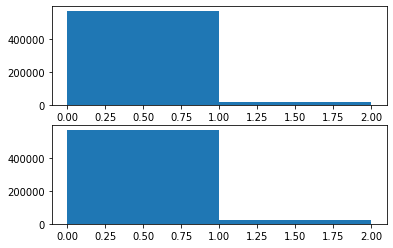

In [20]:
plt.subplot(211)
plt.hist(Y_train, bins=[0,1,2])

plt.subplot(212)
plt.hist(Y_train, bins=[0,1,2])

fraud_count = np.unique(Y_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

**Downsampling and upsampling**

In [21]:
downsampling_factor = 1
indices_1 = np.argwhere(np.array(Y_train)==1)
indices_0_new = np.argwhere(np.array(Y_train)==0)
indices = np.arange(0,len(indices_0_new),downsampling_factor)
indices_0_new = indices_0_new[indices]

print(indices_0_new.shape)

upsampling_factor = 10
indices_1_new = indices_1
for i in range(upsampling_factor):
  indices_1_new = np.concatenate((indices_1_new, indices_1), axis=0)

indices_0_new = np.concatenate((indices_1_new, indices_0_new), axis=0)

indices_0_new = tf.random.shuffle(indices_0_new)

X_new = np.array(X_train)[indices_0_new]
Y_new = np.array(Y_train)[indices_0_new]

X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, test_size=0.01)

X_to_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[2]))
Y_to_train = np.squeeze(Y_train, axis=1)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[2]))
Y_test = np.squeeze(Y_test, axis=1)


print(X_to_train.shape, X_test.shape)

(569877, 1)
(789198, 520) (7972, 520)


**Check the imbalane of the train/test dataset**

Percentage of Fraud: 28.51%


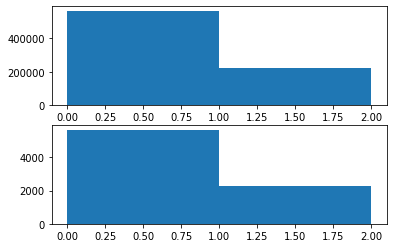

In [22]:
X_new = None
Y_new = None
test_merged_data = None

plt.subplot(211)
plt.hist(Y_to_train, bins=[0,1,2])

plt.subplot(212)
plt.hist(Y_test, bins=[0,1,2])

X_train = None
Y_train = None
X = None
Y = None

fraud_count = np.unique(Y_to_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

# ***The model using NN***

In [23]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [24]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def create_model(dense1=128, dense2=64, dense3=32, dropout_rate=0.4, l1_rate=0.001, l2_rate=0.001, init_std=0.01, lr=0.001):
  out_model = Sequential()
  
  out_model.add(Dense(dense1, activation='relu',
                      input_shape=(X_to_train.shape[1],),
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(dense1, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(dense2, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(dense3, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(1, activation="sigmoid"))

  out_model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=[METRICS])
  
  return out_model

In [48]:
#my_model = create_model(dense1=256, dense2=256, dropout_rate=0.4, l1_rate=1e-4, l2_rate=5e-4, init_std=0.1, lr=0.00008)
my_model = create_model(dense1=512, dense2=128, dense3=32, dropout_rate=0.4, l1_rate=1e-3, l2_rate=1e-3, init_std=0.01, lr=0.000005)
#my_model = tf.keras.models.load_model('./best_model.h5')
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               266752    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)              

In [49]:
BATCH_SIZE = 128
NB_EPOCH = 2000
PATIENCE = 10

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=PATIENCE, verbose=0, mode='max',
    baseline=None)

best_model_hold = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model.h5', monitor='val_auc', verbose=1, save_best_only=True,
    save_weights_only=False, mode='max')

history = my_model.fit(X_to_train, Y_to_train, verbose=0,
             batch_size=BATCH_SIZE, epochs=NB_EPOCH,
             validation_split=0.01, shuffle=True,
             callbacks=[early_stop, best_model_hold])


Epoch 00001: val_auc improved from -inf to 0.85758, saving model to ./best_model.h5

Epoch 00002: val_auc improved from 0.85758 to 0.86892, saving model to ./best_model.h5

Epoch 00003: val_auc improved from 0.86892 to 0.87813, saving model to ./best_model.h5

Epoch 00004: val_auc improved from 0.87813 to 0.88567, saving model to ./best_model.h5

Epoch 00005: val_auc improved from 0.88567 to 0.88773, saving model to ./best_model.h5

Epoch 00006: val_auc improved from 0.88773 to 0.89508, saving model to ./best_model.h5

Epoch 00007: val_auc did not improve from 0.89508

Epoch 00008: val_auc improved from 0.89508 to 0.90043, saving model to ./best_model.h5

Epoch 00009: val_auc improved from 0.90043 to 0.90387, saving model to ./best_model.h5

Epoch 00010: val_auc improved from 0.90387 to 0.90579, saving model to ./best_model.h5

Epoch 00011: val_auc improved from 0.90579 to 0.90919, saving model to ./best_model.h5

Epoch 00012: val_auc improved from 0.90919 to 0.90951, saving model to 

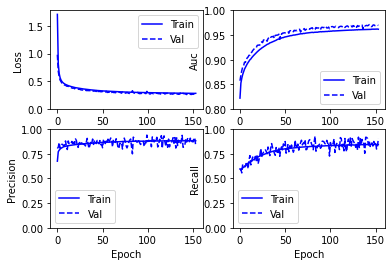

In [50]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1) 
    plt.plot(history.epoch,  history.history[metric], color='b', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='b', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)


**F1 validation (From https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model)**

In [51]:
# Save model weights to drive
!cp -r best_model.h5 '/content/gdrive/My Drive/Kaggle/best_model_20200828_METRICS.h5'

#new_model = tf.keras.models.load_model('./best_model.h5', custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU(alpha=0.3)})
new_model = tf.keras.models.load_model('./best_model.h5')
#new_model = tf.keras.models.load_model('/content/gdrive/My Drive/Kaggle/best_model_20200816_METRICS.h5')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               266752    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)              

In [52]:
def precision_cal(y_pred, y_ref):
  pre = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    if true_pos == len(indices_positive):
      false_pos = 0
    else:
      false_pos = len(indices_positive) - true_pos

    pre = true_pos/(true_pos + false_pos)
  return pre

def recall_cal(y_pred, y_ref):
  recall = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    fals_neg = np.sum(y_ref[np.argwhere(y_pred == 0)])
       
    recall = true_pos/(true_pos + fals_neg)

  return recall

def F1_score(model, X_test, y_ref, test_size, threshold=0.5):
  test_size = test_size
  y_pred = (model.predict(X_test, batch_size=128)>threshold).astype(int)
  y_pred = np.squeeze(y_pred, axis=1)
 
  precision = precision_cal(y_pred, y_ref)
  recall = recall_cal(y_pred, y_ref)

  return precision, recall, 2*precision*recall/(precision+recall)

In [53]:
pre = []
re = []
f1 = []

pre_train = []
re_train = []
f1_train = []

threshold_value = []
indices = np.random.randint(0, len(X_to_train), size=(len(Y_test),))

for i in range(90):
  threshold_value.append(0.1+i*0.01)
  temp_pre, temp_re, temp_f1 = F1_score(new_model, X_test, Y_test, test_size=len(Y_test), threshold=threshold_value[-1])
  
  pre.append(temp_pre)
  re.append(temp_re)
  f1.append(temp_f1)

  temp_pre, temp_re, temp_f1 = F1_score(new_model, X_to_train[indices], Y_to_train[indices], test_size=len(Y_to_train[indices]), threshold=threshold_value[-1])

  pre_train.append(temp_pre)
  re_train.append(temp_re)
  f1_train.append(temp_f1)


0.8720682302771855 0.8712619300106044 0.8714438502673796 0.43000000000000005
0.8889883616830797 0.8888393851637337 0.8855340243352862 0.52


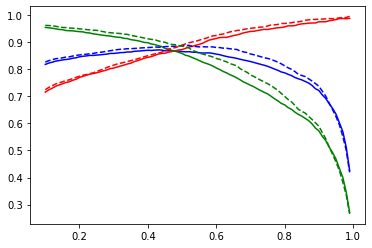

In [54]:
plt.plot(threshold_value, f1, 'b')
plt.plot(threshold_value, pre, 'r')
plt.plot(threshold_value, re, 'g')

plt.plot(threshold_value, f1_train, '--b')
plt.plot(threshold_value, pre_train, '--r')
plt.plot(threshold_value, re_train, '--g')

max_f1_indices = np.where(f1==np.max(f1))[0][0]
max_f1_train_indices = np.where(f1_train==np.max(f1_train))[0][0]
print(f1[max_f1_indices], f1[max_f1_indices-1], f1[max_f1_indices+1], threshold_value[max_f1_indices])
print(f1_train[max_f1_train_indices], f1_train[max_f1_train_indices-1], f1_train[max_f1_train_indices+1], threshold_value[max_f1_train_indices])

In [55]:
def plot_cm(labels, predictions, p=0.5, display=True):
  cm = confusion_matrix(labels, predictions > p)
  if display:
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
  pre = cm[1][1]/(cm[1][1] + cm[0][1])
  recall = cm[1][1]/(cm[1][1] + cm[1][0])
  f1_score = 2*pre*recall/(pre+recall)
  return pre, recall, f1_score

loss :  0.2755747139453888
tp :  1978.0
fp :  287.0
tn :  5382.0
fn :  325.0
accuracy :  0.923231303691864
precision :  0.873289167881012
recall :  0.8588797450065613
auc :  0.9675198197364807

Legitimate Transactions Detected (True Negatives):  5327
Legitimate Transactions Incorrectly Detected (False Positives):  342
Fraudulent Transactions Missed (False Negatives):  258
Fraudulent Transactions Detected (True Positives):  2045
Total Fraudulent Transactions:  2303


(0.8567239212400503, 0.88797221016066, 0.8720682302771855)

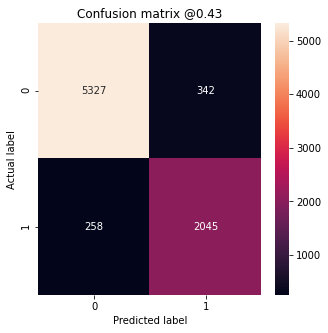

In [56]:
BATCH_SIZE = 128
baseline_results = new_model.evaluate(X_test, Y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(new_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

predictions = new_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

plot_cm(Y_test, predictions, p=threshold_value[max_f1_indices], display=True)


0.8720682302771855 0.8712619300106044 0.8714438502673796 0.43000000000000005


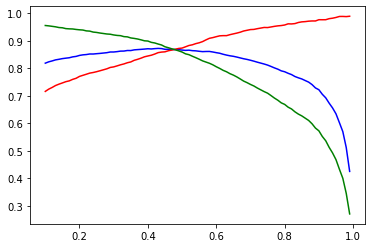

In [57]:
pre2 = []
re2 = []
f12 = []

threshold_value = []

for i in range(90):
  threshold_value.append(0.1+i*0.01)
  temp_pre, temp_re, temp_f1 = plot_cm(Y_test, predictions, p=threshold_value[-1], display=False)
  
  pre2.append(temp_pre)
  re2.append(temp_re)
  f12.append(temp_f1)

plt.plot(threshold_value, f12, 'b')
plt.plot(threshold_value, pre2, 'r')
plt.plot(threshold_value, re2, 'g')

max_f12_indices = np.where(f1==np.max(f12))[0][0]
print(f12[max_f12_indices], f12[max_f12_indices-1], f12[max_f12_indices+1], threshold_value[max_f12_indices])

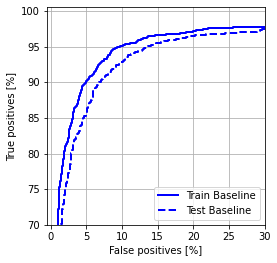

In [58]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,30])
  plt.ylim([70,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

indices = np.random.randint(0, len(X_to_train), size=(len(Y_test),))

train_prediction = new_model.predict(X_to_train[indices], batch_size=BATCH_SIZE, verbose=0)
plot_roc("Train Baseline", Y_to_train[indices], train_prediction, color='b')
plot_roc("Test Baseline", Y_test, predictions, color='b', linestyle='--')
plt.legend(loc='lower right')

Percentage of Fraud: 29.82% 28.89%


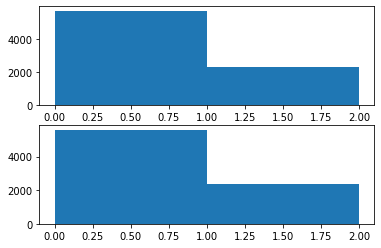

In [36]:
prediction = np.squeeze(predictions, axis=1)
threshold = threshold_value[max_f1_indices]
plt.subplot(211)
plt.hist(Y_test, bins=[0,1,2])

plt.subplot(212)
plt.hist((prediction>threshold).astype('int'), bins=[0,1,2])

fraud_predict = np.unique((prediction>threshold).astype('int'), return_counts=True)
fraud_real = np.unique(Y_test, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_predict[1][1]/np.sum(fraud_predict[1])*100,2)) + "% " + str(round(fraud_real[1][1]/np.sum(fraud_real[1])*100,2)) + "%")



# ***Output the result into a file for a validation with Kaggle***

In [37]:
import os
os.chdir("/content")
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv', names=saved_columns, header=0)
test_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [38]:
dataset_transaction = None
to_remove_id = ['DeviceInfo', 'id_30', 'id_31', 'id_33']
for column in to_remove_id:
  a = test_identity.pop(column)
  

In [ ]:
test_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,NaN,F,F,T,F,mobile
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,24.0,match_status:2,T,F,T,T,mobile
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,NaN,F,T,T,F,desktop
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,NaN,F,F,T,F,mobile
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,NaN,F,F,T,F,mobile


In [40]:
# Remove the columns in to_remove_NaN_dataset_transaction and to_remove_NaN_dataset_identity
#for column in to_remove_NaN_dataset_transaction:
#  test_transaction.pop(column)

#for column in to_remove_NaN_dataset_identity:
#  test_identity.pop(column)

In [39]:
merged_data = pd.merge(left=test_transaction, right=test_identity, how='left', left_on='TransactionID', right_on='TransactionID')

TransactionID = merged_data.pop('TransactionID')
test_transaction = None
merged_data.shape

(506691, 428)

In [41]:
test_transaction = copy.copy(merged_data)
merged_data = None
float_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('O'))].to_list()

print(len(float_columns_test), len(int_columns_test), len(obj_columns_test))

399 2 27


In [42]:
def apply_normalization(X, indices, cache_min, cache_max, cache_mean, cache_median):
  X_out = copy.copy(X)
  #X_out[indices] = (X_out[indices] - cache_mean)/(cache_max - cache_min)
  X_out[np.where(np.isnan(X_out))[0]] = cache_median
  X_out = (X_out - cache_mean)/(cache_max - cache_min)
  #X_out[np.where(np.isnan(X_out))[0]] = 0.0
  return X_out.astype('float16')  


In [43]:
for column in float_columns_test:
  # Set to float 16
  test_transaction[column].astype('float32')

  # Code the NaN feature
  # test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X.to_numpy(), indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], cache[column+'_median'])

In [44]:
for column in int_columns_test:
  # Set to int 32
  test_transaction[column].astype('int32')

  # Code the NaN feature
  # test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X.to_numpy(), indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], cache[column+'_median'])

In [45]:
encoded_column = 0
for column in obj_columns_test:
  ohc = OneHotEncoder(handle_unknown='ignore')
  ohc.fit(cache[column])
  test_transaction.loc[np.where(test_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.transform(test_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(cache[column])))])
  test_transaction = pd.concat([test_transaction, pd_encoded], axis=1)
  encoded_column += len(pd_encoded.columns)

print("Encoded columns: " + str(encoded_column))


for column in obj_columns_test:
  try:
    test_transaction.pop(column)
  except KeyError:
    pass

for column in to_remove:
  try:
    test_transaction.pop(column)
  except KeyError:
    pass



Encoded columns: 207


In [49]:
# Check if we have the same shape with the X_train
#print(test_transaction.shape, X_train.shape)
print(test_transaction.shape, np.any(np.isnan(test_transaction)))

(506691, 520) False


In [48]:
test_transaction.head(5)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,...,id_15_0,id_15_1,id_15_2,id_15_3,id_16_0,id_16_1,id_16_2,id_23_0,id_23_1,id_23_2,id_23_3,id_27_0,id_27_1,id_27_2,id_28_0,id_28_1,id_28_2,id_29_0,id_29_1,id_29_2,id_34_0,id_34_1,id_34_2,id_34_3,id_34_4,id_35_0,id_35_1,id_35_2,id_36_0,id_36_1,id_36_2,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,0.70166,-0.003227,0.029327,-0.502930,-0.024384,0.195068,-0.274414,0.002167,-0.011421,-0.016769,-0.001727,-0.001629,-0.000217,-0.001817,-0.007370,-0.002251,-0.001264,-0.001544,0.007236,-0.001609,-0.001644,-0.000965,0.028259,-0.001606,0.507324,0.389648,-0.001640,0.260254,-0.018723,-0.072998,-0.049408,-0.063354,0.110229,0.335693,0.078003,-0.073914,-0.021133,-0.053894,0.254883,0.000055,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
1,0.70166,-0.002693,-0.323486,-0.502930,-0.024384,0.195068,0.018784,0.002167,-0.011131,-0.016769,-0.002367,-0.002331,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.011810,-0.001609,-0.002899,-0.000965,-0.007038,-0.004406,0.085388,-0.032135,-0.026062,0.498535,-0.043152,-0.072998,-0.049408,-0.063354,0.110229,0.122192,0.674316,-0.073914,-0.021133,-0.053894,0.488770,0.000055,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,0.70166,0.001126,-0.311768,0.422852,-0.024384,0.195068,0.411865,0.002167,0.244629,-0.016769,-0.002581,-0.002331,-0.000217,-0.001817,-0.015961,-0.001807,-0.001264,-0.001544,-0.002287,-0.001609,-0.002584,-0.001279,-0.003613,-0.004406,0.066650,-0.050873,-0.022400,-0.043396,-0.039490,-0.072998,-0.049408,-0.063354,0.110229,0.013718,-0.014694,-0.073914,-0.021133,-0.053894,-0.069397,0.000055,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
3,0.70166,0.004696,0.062683,-0.005112,-0.024384,-0.242920,-0.194824,0.002167,-0.009865,-0.016769,-0.001941,-0.002331,-0.000217,-0.001817,-0.013100,-0.003582,-0.001264,-0.001544,-0.011810,-0.001609,-0.002584,-0.001279,-0.008751,-0.003006,-0.081787,-0.199341,0.015457,0.102905,-0.001631,-0.072998,-0.049408,-0.063354,0.110229,0.134766,0.131958,-0.073914,-0.021133,-0.053894,0.081360,0.000055,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
4,0.70166,-0.002100,0.466797,0.178833,-0.024384,-0.600586,-0.060760,0.002167,-0.010941,-0.016769,-0.001727,-0.001629,-0.000217,-0.001817,-0.010231,-0.001807,-0.001264,-0.001544,0.002476,-0.001609,-0.001330,-0.001279,-0.006355,-0.001606,-0.113037,-0.230591,-0.034607,-0.119080,-0.051697,-0.072998,-0.049408,-0.063354,0.110229,-0.116394,-0.172363,-0.073914,-0.021133,-0.053894,-0.147339,0.000055,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0


In [59]:
# Make the prediction and submit the output
threshold = threshold_value[max_f1_indices]
#threshold = 0.4
result = (new_model.predict(test_transaction, batch_size=BATCH_SIZE)>threshold).astype('int8')
result_pd = pd.DataFrame(result, columns=['isFraud'])
data_to_file = pd.concat([TransactionID, result_pd], axis=1)
data_to_file.head(5)
data_to_file.to_csv("./submission.csv", index=False)
data_to_file.to_csv('/content/gdrive/My Drive/Kaggle/submission.csv', index=False)

In [60]:
!kaggle competitions submit -c ieee-fraud-detection -f submission.csv -m "New submission with model_20200828 with threshold {threshold}"

100% 4.83M/4.83M [00:03<00:00, 1.62MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

# ***Debug zone***

In [64]:
print(np.sum(result==[1]), np.sum(result==[1])/len(result)*100)

53593 10.577057812355065


In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder()
a = {'a': ['Null', 'A', 'B', 'C', 'D']}
df = pd.DataFrame(a)
df
encoded = ohc.fit_transform(df['a'].values.reshape(-1,1)).toarray()    
pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=["a"+"_"+str(i) for i in range(len(np.unique(df['a'].astype('str'))))])
pd_encoded


,a_0,a_1,a_2,a_3,a_4
0,0,0,0,0,1
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,1,0


In [44]:
# Check the similarity of the Object type columns
import os
import pandas as pd
import numpy as np
os.chdir("/content")
dataset_transaction = pd.read_csv('train_transaction.csv')
testset_transaction = pd.read_csv('test_transaction.csv')
#dataset_transaction = pd.read_csv('train_identity.csv')
#saved_columns = dataset_transaction.columns.to_list()
#testset_transaction = pd.read_csv('test_identity.csv', names=saved_columns, header=0)
obj_columns_data = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('O'))].to_list()
obj_columns_test = testset_transaction.columns[np.where(testset_transaction.dtypes == np.dtype('O'))].to_list()


In [37]:
testset_transaction.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [45]:
print(len(obj_columns_data), len(obj_columns_test), set(obj_columns_data) == set(obj_columns_test))
print(obj_columns_data)
print(obj_columns_test)
ignore_columns = ['DeviceInfo', 'id_30', 'id_31', 'id_33']
for column in obj_columns_data:
  data = np.unique(dataset_transaction[column].to_list())
  test = np.unique(testset_transaction[column].to_list())
  if not (set(data)==set(test)):
    print(column)
    if column not in ignore_columns:
      print(data, test)
      for each_data in test:
        if each_data not in data:
          print(each_data)
    else:
      print(column in ignore_columns)

14 14 True
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
card6
['charge card' 'credit' 'debit' 'debit or credit' 'nan'] ['charge card' 'credit' 'debit' 'nan']
P_emaildomain
['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'nan' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'servicios-ta.com' 'sud

In [46]:
np.where(testset_transaction['P_emaildomain'] == "scranton.edu")

(array([480814, 480819]),)

In [48]:
# Check the similarity of the Float columns
float_columns_data = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
float_columns_test = testset_transaction.columns[np.where(testset_transaction.dtypes == np.dtype('O'))].to_list()

for column in float_columns_data:
  if np.max(dataset_transaction[column]) < np.max(testset_transaction[column]):
    print(column, np.max(dataset_transaction[column]), np.max(testset_transaction[column]))

card3 231.0 232.0
C3 26.0 31.0
C5 349.0 376.0
C9 210.0 572.0
D1 640.0 641.0
D2 640.0 641.0
D3 819.0 1076.0
D4 869.0 1091.0
D5 819.0 1088.0
D6 873.0 1091.0
D7 843.0 1088.0
D8 1707.7916259765625 2029.5833740234373
D10 876.0 1091.0
D11 670.0 883.0
D12 648.0 879.0
D13 847.0 1066.0
D14 878.0 1085.0
D15 879.0 1091.0
V2 8.0 11.0
V3 9.0 11.0
V4 6.0 10.0
V5 6.0 10.0
V6 9.0 13.0
V7 9.0 13.0
V8 8.0 11.0
V9 8.0 11.0
V10 4.0 5.0
V11 5.0 7.0
V12 3.0 4.0
V15 7.0 13.0
V16 15.0 25.0
V19 7.0 13.0
V20 15.0 25.0
V23 13.0 15.0
V24 13.0 29.0
V25 7.0 13.0
V26 13.0 25.0
V27 4.0 7.0
V28 4.0 7.0
V31 7.0 13.0
V32 15.0 25.0
V33 7.0 13.0
V34 13.0 25.0
V35 3.0 4.0
V36 5.0 6.0
V39 15.0 30.0
V40 24.0 31.0
V43 8.0 11.0
V45 48.0 69.0
V46 6.0 8.0
V49 5.0 7.0
V50 5.0 7.0
V51 6.0 8.0
V54 6.0 7.0
V55 17.0 49.0
V60 16.0 17.0
V63 7.0 8.0
V64 7.0 10.0
V66 7.0 8.0
V67 8.0 10.0
V68 2.0 7.0
V70 6.0 8.0
V73 7.0 8.0
V74 8.0 10.0
V75 4.0 5.0
V76 6.0 7.0
V77 30.0 80.0
V78 31.0 80.0
V84 7.0 10.0
V85 7.0 10.0
V86 30.0 80.0
V87 30.0 80

In [11]:
print(data, test)

['C' 'H' 'R' 'S' 'W'] ['C' 'H' 'R' 'S' 'W']


In [ ]:
b = {'a': ['Null', 'A', 'B', 'C', 'E']}
df_b = pd.DataFrame(b)
ohc_b = OneHotEncoder(handle_unknown='ignore')
ohc_b.fit(df['a'].values.reshape(-1,1))
encoded_b = ohc_b.transform(df_b['a'].values.reshape(-1,1)).toarray()    
pd_encoded_b = pd.DataFrame(encoded_b.astype('int8'), columns=["a"+"_"+str(i) for i in range(len(np.unique(df['a'].astype('str'))))])
pd_encoded_b

,a_0,a_1,a_2,a_3,a_4
0,0,0,0,0,1
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,0,0


In [ ]:
for column in obj_columns:
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  print(column, len(np.unique(dataset_transaction[column].astype("str"))))

ProductCD 5
card4 5
card6 5
P_emaildomain 60
R_emaildomain 61
M1 3
M2 3
M3 3
M4 4
M5 3
M6 3
M7 3
M8 3
M9 3


In [ ]:
for column in obj_columns_test:
  test_transaction.loc[np.where(test_transaction[column].isnull())[0], column] = 'Null'
  print(column, len(np.unique(test_transaction[column].astype("str"))))

ProductCD 5
card4 5
card6 4
P_emaildomain 61
R_emaildomain 61
M1 3
M2 3
M3 3
M4 4
M5 3
M6 3
M7 3
M8 3
M9 3


**Train val dataset**